In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from scipy import stats
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [18]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [19]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df = df[df.schedule_season > 1978]

In [20]:
df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

In [21]:
df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

In [22]:
df = df.fillna(value = 0)

In [23]:
df.index = range(0, len(df))

In [24]:
df.columns

Index(['schedule_season', 'schedule_week', 'team_home', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'weather_detail', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'score_home', 'score_away', 'point_total',
       'over_under_result', 'score_difference', 'home_id', 'away_id',
       'home_favorite', 'favorite_covered', 'winning_team', 'losing_team',
       'home_wins', 'home_losses', 'home_ties', 'away_wins', 'away_losses',
       'away_ties', 'home_points_for', 'home_points_against',
       'away_points_for', 'away_points_against', 'h_games', 'a_games',
       'home_win_pct', 'away_win_pct', 'win_pct_diff', 'h_ppg', 'h_papg',
       'a_ppg', 'a_papg', 'home_pt_diff_pg', 'away_pt_diff_pg', 'pt_diff_pg',
       'home_exp_win_pct', 'away_exp_win_pct', 'home_win_pct_last_4',
       'away_win_pct_last_4', 'exp_win_difference', 'total_ppg',
       'total_points_against', 'last_four_difference'],
      dtype='object')

In [25]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 19) & (df.schedule_season>2001)]

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


-4.420276

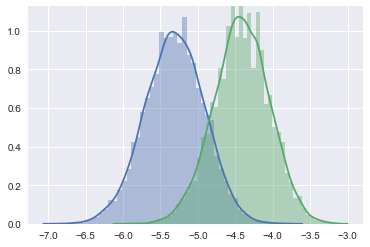

In [194]:
spread_samples = np.random.choice(week5_df.spread_favorite,25)
sample_means = spread_samples.mean()

def n_samples(arr,sample_size,n_samples):
    size = sample_size
    sample_means=[]
    
    for n in range(n_samples):
        sample_means.append(np.random.choice(arr,size).mean())
    
    return sample_means

x = n_samples(week5_df.spread_favorite,25,1000)

#sns.distplot(x)

ax1 = n_samples(week5_df.spread_favorite[(week5_df.spread_favorite>-12.5) & (week5_df.home_favorite==1)],50,15000)
ax2 = n_samples(week5_df.spread_favorite[(week5_df.spread_favorite>-12.5) & (week5_df.home_favorite==0)],50,15000)
sns.distplot(ax1)
sns.distplot(ax2)
sum(week5_df.spread_favorite<-12.5)/len(week5_df)
np.sum(ax1)/len(ax1)
np.sum(ax2)/len(ax2)

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-10, 0)

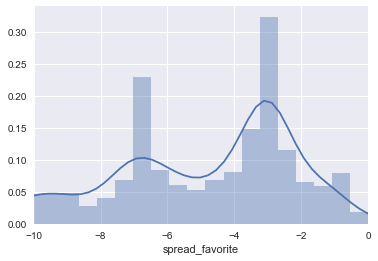

In [37]:
rw5 = np.random.choice(week5_df.spread_favorite,10)

ax = sns.distplot(week5_df.spread_favorite)
ax.set_xlim(-10,0)

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



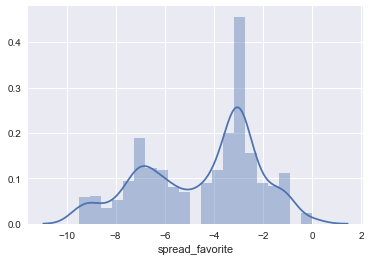

In [1019]:
sns.distplot((reg_df.spread_favorite[reg_df['spread_favorite']>-10]))

In [1020]:
reg_df['spread_favorite'].median()

-4.5

In [1021]:
reg_df.columns

Index(['schedule_season', 'schedule_week', 'team_home', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'weather_detail', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'score_home', 'score_away', 'point_total',
       'over_under_result', 'score_difference', 'home_id', 'away_id',
       'home_favorite', 'favorite_covered', 'winning_team', 'losing_team',
       'home_wins', 'home_losses', 'home_ties', 'away_wins', 'away_losses',
       'away_ties', 'home_points_for', 'home_points_against',
       'away_points_for', 'away_points_against', 'h_games', 'a_games',
       'home_win_pct', 'away_win_pct', 'win_pct_diff', 'h_ppg', 'h_papg',
       'a_ppg', 'a_papg', 'home_pt_diff_pg', 'away_pt_diff_pg', 'pt_diff_pg',
       'home_exp_win_pct', 'away_exp_win_pct', 'home_win_pct_last_4',
       'away_win_pct_last_4', 'exp_win_difference', 'total_ppg',
       'total_points_against', 'last_four_difference'],
      dtype='object')

In [1022]:
pivot = reg_df.pivot_table(index='spread_favorite', columns='favorite_covered',
                    aggfunc={'favorite_covered':len}, fill_value = 0)

In [1023]:
pivot['row_total'] = 0
for index, row in pivot.iterrows():
    row.row_total = sum(row)

In [1024]:
covered = pivot.favorite_covered[1]
no_cover = pivot.favorite_covered[0]
push = pivot.favorite_covered[2]

In [1025]:
spreads = sorted(set(reg_df.spread_favorite))
x = np.array([spread for spread in spreads if spread > -15 and spread < 0])

In [1026]:
y_covered = [covered[value]/pivot['row_total'][value] for value in x]
y_no_cover = [no_cover[value]/pivot['row_total'][value] for value in x]
y_push = [push[value]/pivot['row_total'][value] for value in x]

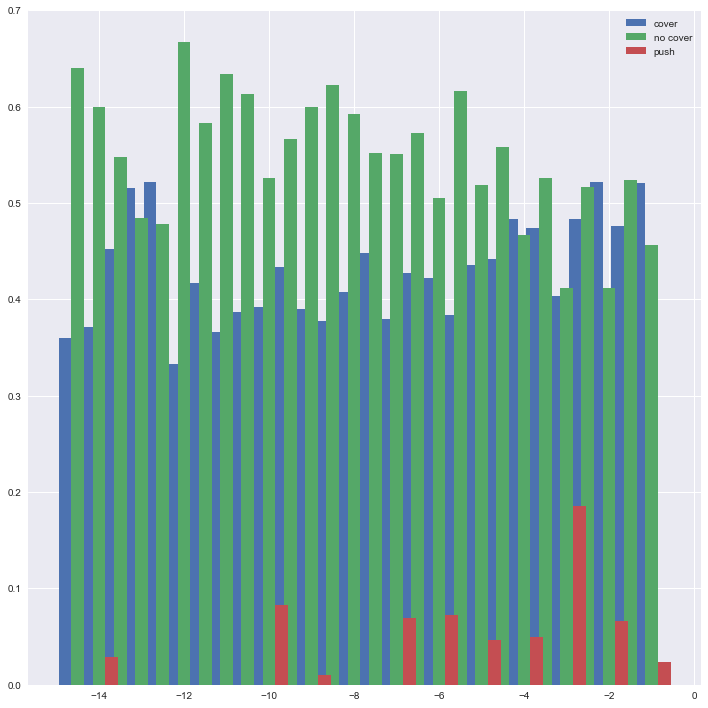

In [1027]:
plt.figure(figsize = (10,10))
plt.bar(x-.3,y_covered, label = 'cover', width = .3)
plt.bar(x,y_no_cover, label = 'no cover', width = .3)
plt.bar(x+.3,y_push, label = 'push', width = .3)
plt.legend()
plt.tight_layout()
plt.show()

In [1028]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=x,
    y=y_covered,
    name='Covered'
)
trace2 = go.Bar(
    x=x,
    y=y_no_cover,
    name='No Cover'
)

trace3 = go.Bar(
    x=x,
    y=y_push,
    name='Push'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [1029]:
x = reg_df.corr()
x_dict = x['over_under_line'].to_dict()
sorted_dict = sorted(x_dict.items(), key = lambda x:x[1])
sorted_dict

[('weather_wind_mph', -0.27814438839587063),
 ('away_losses', -0.09181107897061887),
 ('home_losses', -0.08261468736976238),
 ('weather_humidity', -0.07296270790762051),
 ('favorite_covered', -0.06089438793056482),
 ('home_favorite', -0.04783828371692238),
 ('spread_favorite', -0.02676209774446886),
 ('schedule_week', -0.01590567168302309),
 ('h_games', -0.013207615072821465),
 ('a_games', -0.012557184401268516),
 ('home_ties', -0.009323614004445693),
 ('pt_diff_pg', -0.009019590703124431),
 ('exp_win_difference', -0.0027615639900368705),
 ('win_pct_diff', -0.0016914052458963243),
 ('last_four_difference', 0.0008104096904615186),
 ('score_difference', 0.004869988893768626),
 ('away_ties', 0.0285009517966309),
 ('home_wins', 0.06290691375775394),
 ('away_wins', 0.07262458799908296),
 ('away_points_against', 0.07738696378310155),
 ('home_points_against', 0.09375010316977914),
 ('away_win_pct_last_4', 0.10290023606164597),
 ('home_win_pct_last_4', 0.10353097316603686),
 ('home_win_pct', 0

In [1030]:
reg_df

schedule_season  schedule_week             team_home  \
5387             2002              2       Atlanta Falcons   
5388             2002              2      Baltimore Ravens   
5389             2002              2     Carolina Panthers   
5390             2002              2      Cleveland Browns   
5391             2002              2        Dallas Cowboys   
5392             2002              2    Indianapolis Colts   
5393             2002              2    Kansas City Chiefs   
5394             2002              2     Minnesota Vikings   
5395             2002              2    New Orleans Saints   
5396             2002              2         New York Jets   
5397             2002              2   Pittsburgh Steelers   
5398             2002              2    San Diego Chargers   
5399             2002              2   San Francisco 49ers   
5400             2002              2      Seattle Seahawks   
5401             2002              2        St. Louis Rams   
5402             2002              2   Washington Redskins   
5403             2002              3     Arizona Cardinals   
5404             2002              3       Atlanta Falcons   
5405             2002              3         Chicago Bears   
5406             2002              3        Denver Broncos   
5407             2002              3         Detroit Lions   
5408             2002              3        Houston Texans   
5409             2002              3        Miami Dolphins   
5410             2002              3     Minnesota Vikings   
5411             2002              3  New England Patriots   
5412             2002              3       New York Giants   
5413             2002              3   Philadelphia Eagles   
5414             2002              3   San Francisco 49ers   
5415             2002              3      Tennessee Titans   
5416             2002              3  Tampa Bay Buccaneers   
...               ...            ...                   ...   
9602             2017             16     Arizona Cardinals   
9603             2017             16     Carolina Panthers   
9604             2017             16         Chicago Bears   
9605             2017             16    Cincinnati Bengals   
9606             2017             16        Dallas Cowboys   
9607             2017             16    Kansas City Chiefs   
9608             2017             16  New England Patriots   
9609             2017             16    New Orleans Saints   
9610             2017             16         New York Jets   
9611             2017             16   San Francisco 49ers   
9612             2017             16      Tennessee Titans   
9613             2017             16   Washington Redskins   
9614             2017             16        Houston Texans   
9615             2017             16   Philadelphia Eagles   
9616             2017             17       Atlanta Falcons   
9617             2017             17      Baltimore Ravens   
9618             2017             17        Denver Broncos   
9619             2017             17         Detroit Lions   
9620             2017             17    Indianapolis Colts   
9621             2017             17  Los Angeles Chargers   
9622             2017             17      Los Angeles Rams   
9623             2017             17        Miami Dolphins   
9624             2017             17     Minnesota Vikings   
9625             2017             17  New England Patriots   
9626             2017             17       New York Giants   
9627             2017             17   Philadelphia Eagles   
9628             2017             17   Pittsburgh Steelers   
9629             2017             17      Seattle Seahawks   
9630             2017             17  Tampa Bay Buccaneers   
9631             2017             17      Tennessee Titans   

                 team_away team_favorite_id  spread_favorite  over_under_line  \
5387         Chicago Bears              ATL             -2.5             45.0   

In [1031]:
reg_df.describe()

schedule_season  schedule_week  spread_favorite  over_under_line  \
count      3841.000000    3841.000000      3841.000000      3841.000000   
mean       2009.501953       9.651914        -5.419943        43.199948   
std           4.611360       4.684961         3.426142         4.713206   
min        2002.000000       2.000000       -26.500000        30.000000   
25%        2006.000000       6.000000        -7.000000        40.000000   
50%        2010.000000      10.000000        -4.500000        43.500000   
75%        2014.000000      14.000000        -3.000000        46.500000   
max        2017.000000      17.000000         0.000000        60.000000   

       weather_temperature  weather_wind_mph  weather_humidity   score_home  \
count           3841.00000       3841.000000       3841.000000  3841.000000   
mean              59.83598          6.247852         65.391817    23.253840   
std               15.59030          5.457698         12.433429    10.322451   
min                0.00000          0.000000          4.000000     0.000000   
25%               49.00000          1.000000         64.000000    16.000000   
50%               63.00000          6.000000         66.552000    23.000000   
75%               72.00000         10.000000         68.000000    30.000000   
max               93.00000         40.000000        100.000000    62.000000   

        score_away  point_total          ...           away_pt_diff_pg  \
count  3841.000000  3841.000000          ...               3841.000000   
mean     20.697214    43.951054          ...                  0.306306   
std      10.144719    14.066498          ...                  8.134176   
min       0.000000     3.000000          ...                -42.000000   
25%      13.000000    34.000000          ...                 -5.000000   
50%      20.000000    43.000000          ...                  0.500000   
75%      27.000000    53.000000          ...                  5.571000   
max      59.000000   106.000000          ...                 42.000000   

        pt_diff_pg  home_exp_win_pct  away_exp_win_pct  home_win_pct_last_4  \
count  3841.000000       3841.000000       3841.000000          3841.000000   
mean     -0.581775          0.489658          0.512084             0.409691   
std      11.366746          0.316927          0.318766             0.276171   
min     -52.000000          0.000000          0.000000             0.000000   
25%      -7.667000          0.193552          0.217616             0.250000   
50%      -0.428000          0.486835          0.529577             0.500000   
75%       6.875000          0.781734          0.812959             0.500000   
max      54.000000          1.000000          1.000000             1.000000   

       away_win_pct_last_4  exp_win_difference    total_ppg  \
count          3841.000000         3841.000000  3841.000000   
mean              0.427428           -0.022467    43.668854   
std               0.275013            0.447746     8.266455   
min               0.000000           -0.998244     0.000000   
25%               0.250000           -0.336171    38.300000   
50%               0.500000           -0.017929    43.500000   
75%               0.500000            0.289001    48.910000   
max               1.000000            1.000000    83.000000   

       total_points_against  last_four_difference  
count           3841.000000           3841.000000  
mean              43.637272             -0.017736  
std                7.647113              0.361957  
min                9.000000             -1.000000  
25%               38.890000             -0.250000  
50%               43.730000              0.000000  
75%               48.500000              0.250000  
max               88.000000              1.000000  

[8 rows x 43 columns]

In [1074]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
#     split = train_test_split(x, y)
#     X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
#     x = X_train
#     y = y_train
#     plt.scatter(x, y, s = s, alpha = alpha)
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [1033]:
def regression_evaluation(target, X_list):
    target = target
    X = X_list 
    X2 = sm.add_constant(X)
    # model = sm.ols(formula = 'over_under_line ~ np.power(total_points_against, 1)', data = reg_df).fit()

    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [1034]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

# OVER/UNDER

# Variable 1 -Total Points Against

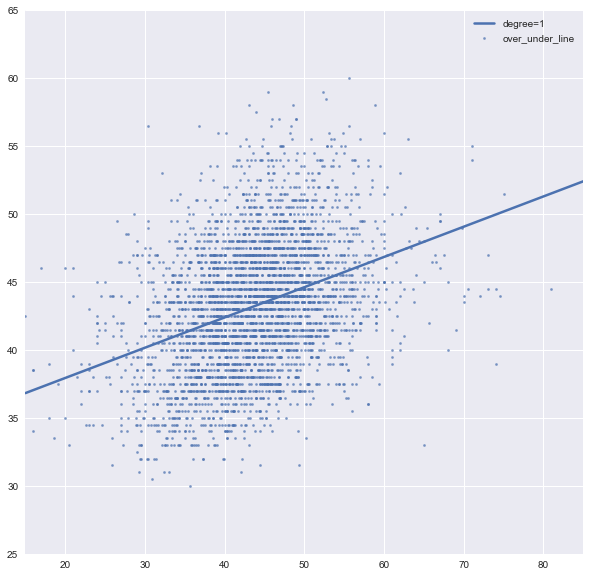

In [1035]:
poly_regression((reg_df.total_points_against), reg_df.over_under_line, [1],15,85, 25, 65,10,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     576.3
Date:                Thu, 09 Aug 2018   Prob (F-statistic):          8.92e-119
Time:                        17:54:19   Log-Likelihood:                -11136.
No. Observations:                3841   AIC:                         2.228e+04
Df Residuals:                    3839   BIC:                         2.229e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   33.4830 

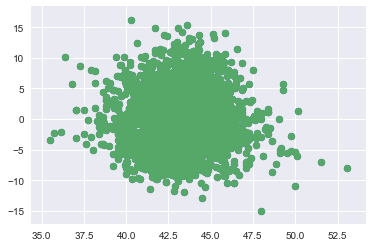

In [1036]:
regression_evaluation(reg_df.over_under_line, reg_df.total_points_against)

# VARIABLE 2 -TOTAL PPG

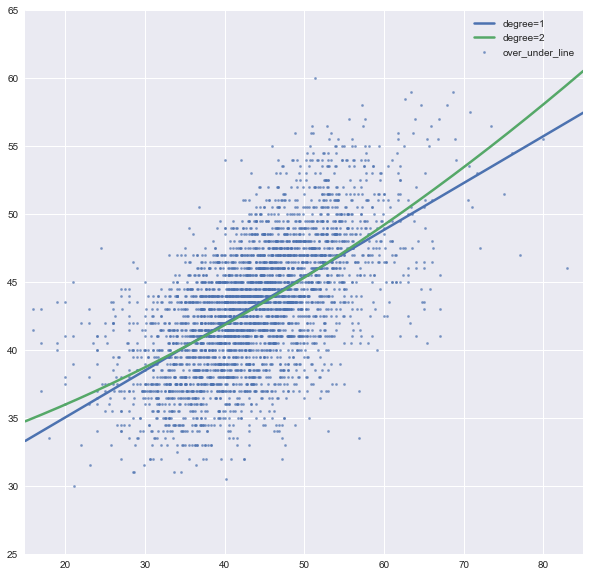

In [1037]:
poly_regression((reg_df.total_ppg), reg_df.over_under_line, [1,2],15,85, 25, 65,10,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     2218.
Date:                Thu, 09 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:54:20   Log-Likelihood:                -10529.
No. Observations:                3841   AIC:                         2.106e+04
Df Residuals:                    3839   BIC:                         2.107e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.1329      0.326     86.404      0.0

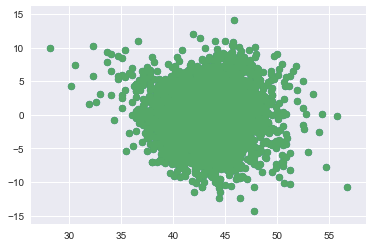

In [1038]:
regression_evaluation(reg_df.over_under_line, (reg_df.total_ppg**1))

## VARIABLE 3 -WEATHER HUMIDITY

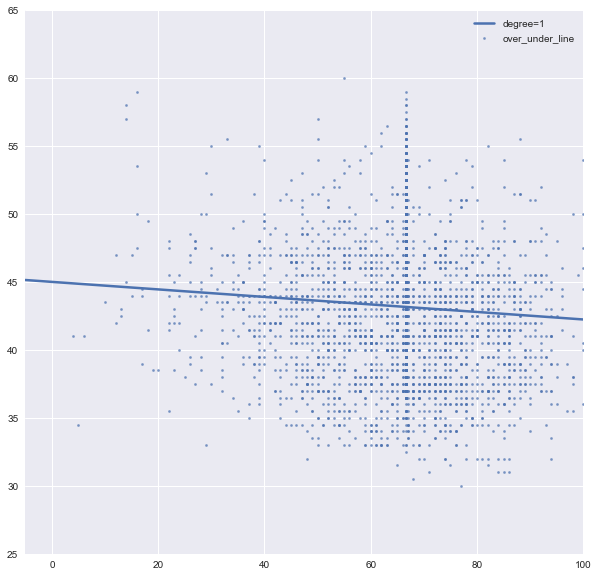

In [1039]:
poly_regression(reg_df.weather_humidity, reg_df.over_under_line, [1],-5,100, 25, 65,-15,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     20.55
Date:                Thu, 09 Aug 2018   Prob (F-statistic):           6.00e-06
Time:                        17:54:21   Log-Likelihood:                -11394.
No. Observations:                3841   AIC:                         2.279e+04
Df Residuals:                    3839   BIC:                         2.281e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               45.0086      0.406  

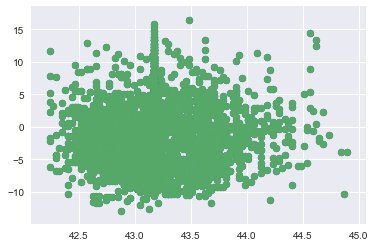

In [1040]:
regression_evaluation(reg_df.over_under_line, (reg_df.weather_humidity**1))

# VARIABLE 4 - WIND MPH

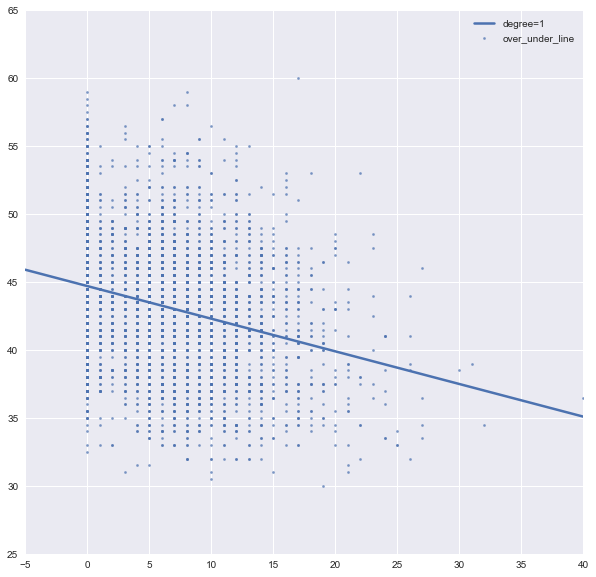

In [1041]:
poly_regression(reg_df.weather_wind_mph, reg_df.over_under_line, [1],-5,40, 25, 65,-10,60)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     321.9
Date:                Thu, 09 Aug 2018   Prob (F-statistic):           3.47e-69
Time:                        17:54:22   Log-Likelihood:                -11250.
No. Observations:                3841   AIC:                         2.250e+04
Df Residuals:                    3839   BIC:                         2.252e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               44.7007      0.111  

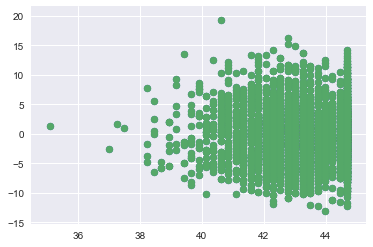

In [1042]:
regression_evaluation(reg_df.over_under_line, (reg_df.weather_wind_mph**1))

# VARIABLE 5 - Weather Temp

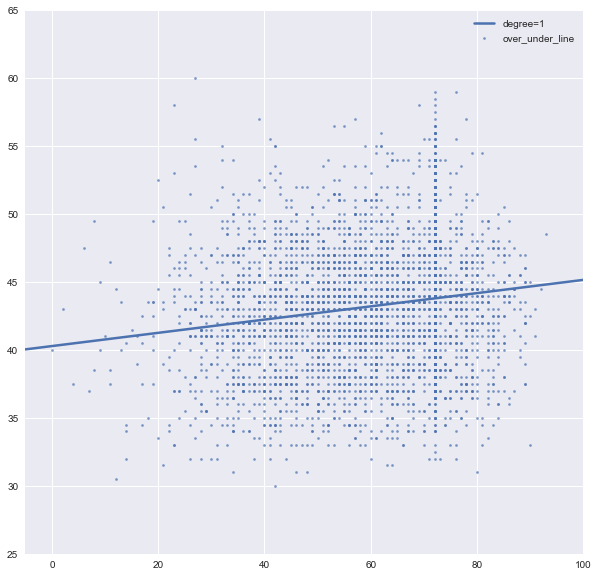

In [1043]:
poly_regression(reg_df.weather_temperature, reg_df.over_under_line, [1],-5,100, 25, 65,-10,110)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     102.4
Date:                Thu, 09 Aug 2018   Prob (F-statistic):           9.20e-24
Time:                        17:54:22   Log-Likelihood:                -11354.
No. Observations:                3841   AIC:                         2.271e+04
Df Residuals:                    3839   BIC:                         2.272e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.2849    

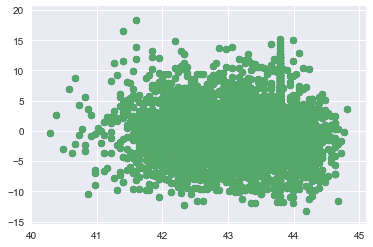

In [1044]:
regression_evaluation(reg_df.over_under_line, (reg_df.weather_temperature**1))

# ALL VARIABLES FOR OVER/UNDER

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     1000.
Date:                Thu, 09 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:54:23   Log-Likelihood:                -9801.6
No. Observations:                3841   AIC:                         1.962e+04
Df Residuals:                    3835   BIC:                         1.965e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.9184      0.567     31.616      0.0

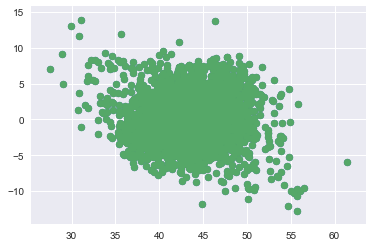

In [1045]:
regression_evaluation(reg_df.over_under_line, reg_df[['weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']].values)

# SPREAD 

# Last 4 Games win %

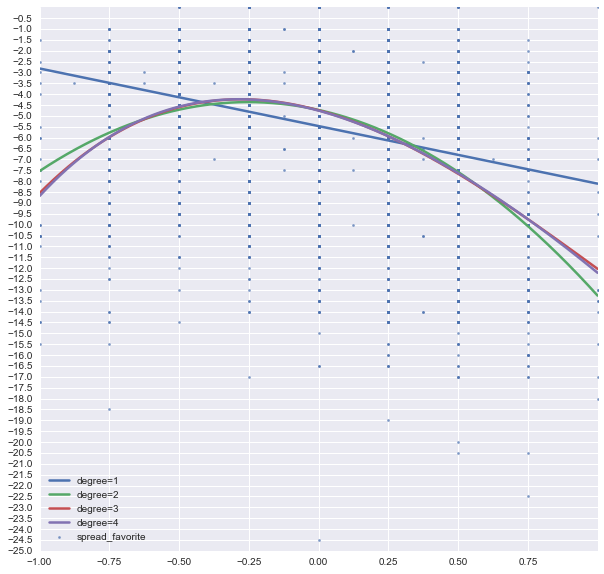

In [1046]:
poly_regression(reg_df.last_four_difference, reg_df.spread_favorite, [1,2,3,4],-1,1, -25, 0,-1,1)
plt.yticks(np.arange(-25,0,.5))
plt.xticks(np.arange(-1,1,.25));

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     326.0
Date:                Thu, 09 Aug 2018   Prob (F-statistic):           5.11e-70
Time:                        17:54:24   Log-Likelihood:                -10023.
No. Observations:                3841   AIC:                         2.005e+04
Df Residuals:                    3839   BIC:                         2.006e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.4669 

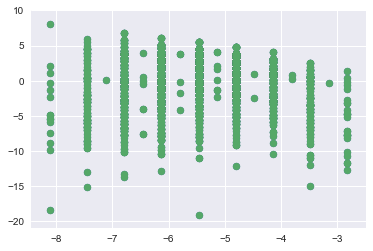

In [1047]:
regression_evaluation(reg_df.spread_favorite, (reg_df.last_four_difference**1))

# WIN % DIFF REJECTED DUE TO LOW HIGH CORRELATION WITH EXP WINS

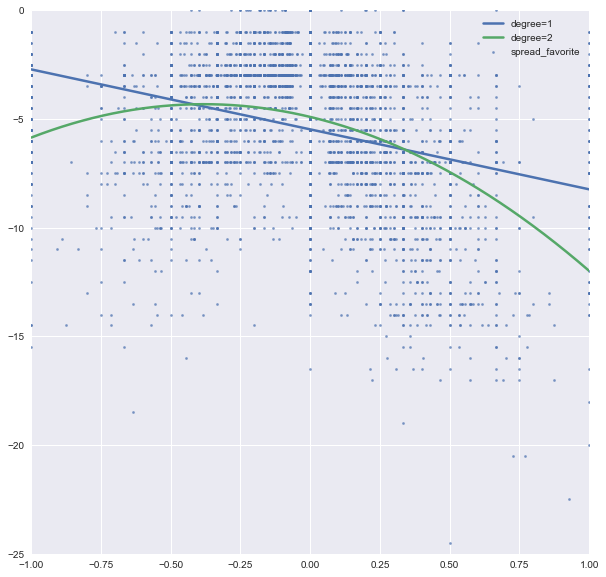

In [1048]:
poly_regression(reg_df.win_pct_diff, reg_df.spread_favorite, [1,2],-1,1, -25, 0,-1,1)

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     394.6
Date:                Thu, 09 Aug 2018   Prob (F-statistic):           1.17e-83
Time:                        17:54:25   Log-Likelihood:                -9991.7
No. Observations:                3841   AIC:                         1.999e+04
Df Residuals:                    3839   BIC:                         2.000e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.4802      0.053   -103.916   

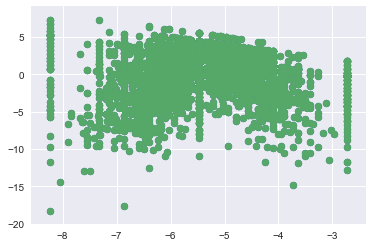

In [1049]:
regression_evaluation(reg_df.spread_favorite, (reg_df.win_pct_diff**1))

# First Variable- Home Favorite

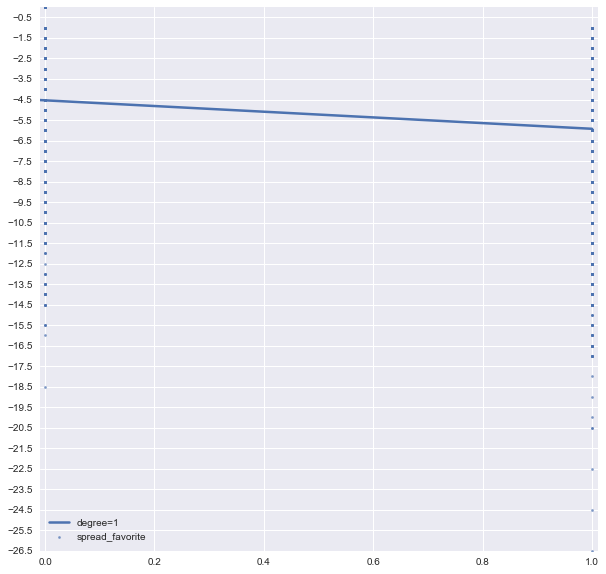

In [1050]:
poly_regression(reg_df.home_favorite, reg_df.spread_favorite, [1],-.01,1.01, -25, 0,-1,1)
plt.yticks(np.arange(-26.5,0,1));

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     151.9
Date:                Thu, 09 Aug 2018   Prob (F-statistic):           2.90e-34
Time:                        17:54:26   Log-Likelihood:                -10105.
No. Observations:                3841   AIC:                         2.021e+04
Df Residuals:                    3839   BIC:                         2.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.5399      0.090    -50.634

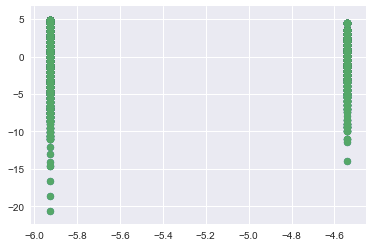

In [1051]:
regression_evaluation(reg_df.spread_favorite, (reg_df.home_favorite**1))

In [1052]:
# data = {"a":[2, 3, 5], "b":[2, 3, 5], "c":[2, 3, 5]}
# model = sm.ols(formula = 'a ~ np.power(b, 2) + b + c', data = reg_df).fit()

# SECOND VARIABLE - Exp Win Difference

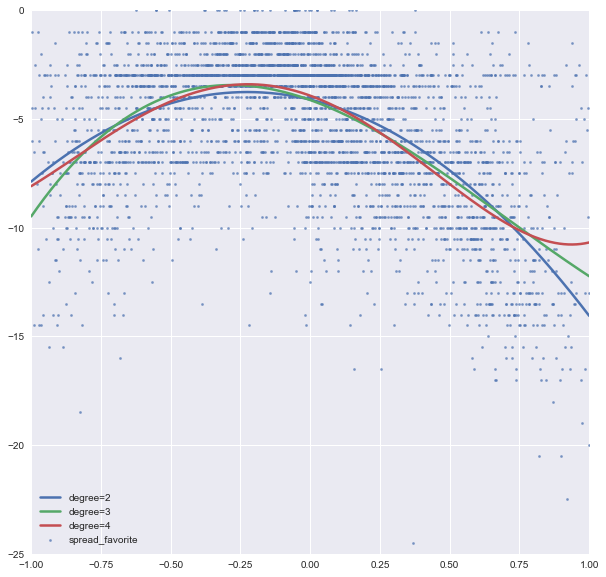

In [1053]:
poly_regression(reg_df.exp_win_difference, reg_df.spread_favorite, [2,3,4],-1,1, -25, 0,-1,1)

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     897.4
Date:                Thu, 09 Aug 2018   Prob (F-statistic):          2.22e-177
Time:                        17:54:26   Log-Likelihood:                -9776.1
No. Observations:                3841   AIC:                         1.956e+04
Df Residuals:                    3839   BIC:                         1.957e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.1326      0

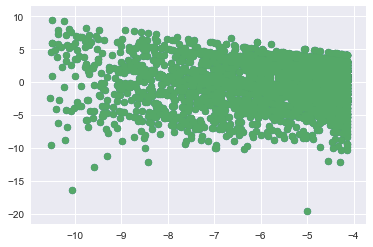

In [1054]:
regression_evaluation(reg_df.spread_favorite, (reg_df.exp_win_difference**2))

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     255.6
Date:                Thu, 09 Aug 2018   Prob (F-statistic):          3.12e-151
Time:                        17:54:27   Log-Likelihood:                -9829.7
No. Observations:                3841   AIC:                         1.967e+04
Df Residuals:                    3837   BIC:                         1.969e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0249      0.069    -87.557      0.0

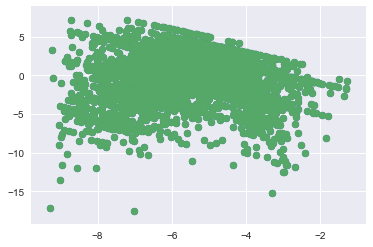

In [1055]:
regression_evaluation(reg_df.spread_favorite, reg_df[['last_four_difference', 'exp_win_difference', 'favorite_covered']].values)

# WEEK- REJECTED LOW PREDICTABILITY

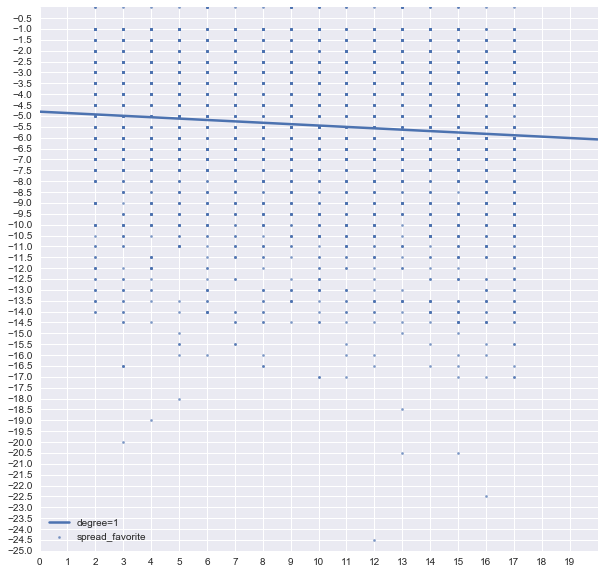

In [1056]:
poly_regression(reg_df.schedule_week, reg_df.spread_favorite, [1],0,20, -25, 0,0,25)
plt.yticks(np.arange(-25,0,.5))
plt.xticks(np.arange(0,20,1));

In [1280]:
# def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
# #     log_x=np.log(x+.01)
# #     log_y=np.log(y+.01)
    
#     split = train_test_split(x,y)
#     print(split[0])
#     print(split[1])
#     print(split[2])
#     print(split[3])

#     X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
#     plt.figure(figsize = (10,10))
#     plt.scatter(X_train, y_train, s = s, alpha = alpha)
#     plt.ylim(ylim_min, ylim_max)
#     plt.xlim(xlim_min,xlim_max)
    
#     log_model = LogisticRegression(random_state=0)
#     #log_model = sm.Logit(y_train,X_train)
#     log_model.fit(x[:, np.newaxis], y)
#     xfit = np.linspace(xfit1,xfit2, 10000)
#     yfit = log_model.predict(xfit[:, np.newaxis])
#     plt.plot(xfit, yfit, linewidth=width)#label = 'degree={}'.format(degree),
# #     for degree in degree_range:
# # #         log_model = make_pipeline(PolynomialFeatures(degree),
# # #                                LogisticRegression())
        
# #         #log_model.fit(log_x[:, np.newaxis], log_y)
        
#     plt.legend(loc = 'best')
    
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+.01), np.log(np.abs(y)+.01))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

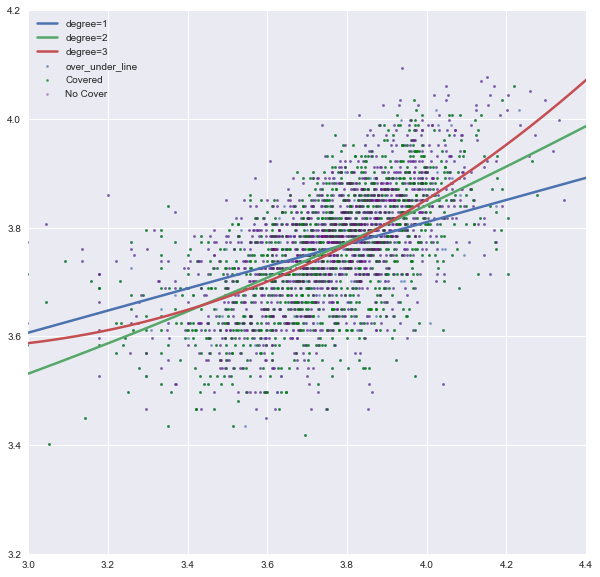

In [1281]:
#poly_regression((reg_df.total_ppg), reg_df.over_under_line, [1,2],15,85, 25, 65,10,150)
log_log_regression(reg_df.total_ppg, reg_df.over_under_line, [1,2,3],3,4.4,3.2,4.2,0,5)
#log_log_regression(reg_df.total_ppg, reg_df.over_under_line, [1,2,3],-15,85,3.2,4.2,15,75)#log-linear reg, change logx to x in function

In [1332]:
def log_regression_evaluation(target, X_list):
    
    split = train_test_split(np.log(X_list+.01), np.log(np.abs(target)+.01))
    ##split = train_test_split(X_list, np.log(np.abs(target)+.01))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)

    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

## all variable over/under log_reg eval

In [1341]:
test_df = reg_df[(reg_df.schedule_week>4)]
test_df[test_df.weather_detail=='DOME']
test_df['dome'] = np.where(test_df['weather_detail']=='DOME', 1, 0)

schedule_season  schedule_week           team_home  \
5431             2002              5     Atlanta Falcons   
5437             2002              5  Indianapolis Colts   
5440             2002              5  New Orleans Saints   
5448             2002              6      Houston Texans   
5449             2002              6  Indianapolis Colts   
5450             2002              6   Minnesota Vikings   
5454             2002              6      St. Louis Rams   
5460             2002              7     Atlanta Falcons   
5463             2002              7       Detroit Lions   
5467             2002              7  New Orleans Saints   
5471             2002              7      St. Louis Rams   
5480             2002              8   Minnesota Vikings   
5482             2002              8  New Orleans Saints   
5488             2002              9     Atlanta Falcons   
5492             2002              9       Detroit Lions   
5493             2002              9      Houston Texans   
5494             2002              9  Indianapolis Colts   
5507             2002             10   Minnesota Vikings   
5515             2002             11     Atlanta Falcons   
5517             2002             11       Detroit Lions   
5518             2002             11      Houston Texans   
5519             2002             11  Indianapolis Colts   
5522             2002             11   Minnesota Vikings   
5530             2002             11      St. Louis Rams   
5537             2002             12      Houston Texans   
5540             2002             12  New Orleans Saints   
5548             2002             13       Detroit Lions   
5553             2002             13  Indianapolis Colts   
5556             2002             13   Minnesota Vikings   
5557             2002             13  New Orleans Saints   
...               ...            ...                 ...   
9509             2017             10     Atlanta Falcons   
9513             2017             10       Detroit Lions   
9514             2017             10  Indianapolis Colts   
9525             2017             11      Dallas Cowboys   
9531             2017             11   Minnesota Vikings   
9532             2017             11  New Orleans Saints   
9536             2017             12      Dallas Cowboys   
9537             2017             12       Detroit Lions   
9539             2017             12   Arizona Cardinals   
9540             2017             12     Atlanta Falcons   
9542             2017             12  Indianapolis Colts   
9552             2017             13      Dallas Cowboys   
9553             2017             13   Arizona Cardinals   
9554             2017             13     Atlanta Falcons   
9562             2017             13  New Orleans Saints   
9568             2017             14     Atlanta Falcons   
9569             2017             14   Arizona Cardinals   
9575             2017             14      Houston Texans   
9584             2017             15  Indianapolis Colts   
9585             2017             15       Detroit Lions   
9591             2017             15   Minnesota Vikings   
9592             2017             15  New Orleans Saints   
9602             2017             16   Arizona Cardinals   
9606             2017             16      Dallas Cowboys   
9609             2017             16  New Orleans Saints   
9614             2017             16      Houston Texans   
9616             2017             17     Atlanta Falcons   
9619             2017             17       Detroit Lions   
9620             2017             17  Indianapolis Colts   
9624             2017             17   Minnesota Vikings   

                 team_away team_favorite_id  spread_favorite  over_under_line  \
5431  Tampa Bay Buccaneers              ATL             -2.5             38.5   
5437    Cincinnati Bengals              IND            -13.5             43.0   
5440   Pittsburgh Steelers               N

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     839.6
Date:                Thu, 09 Aug 2018   Prob (F-statistic):               0.00
Time:                        19:57:29   Log-Likelihood:                 3162.7
No. Observations:                2332   AIC:                            -6311.
Df Residuals:                    2325   BIC:                            -6271.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7245      0.057     12.804      0.0

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



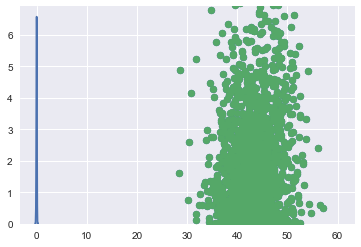

In [1352]:
log_regression_evaluation(test_df.over_under_line, test_df[['dome','weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']].values)
regression_evaluation(test_df.over_under_line, test_df[['dome','weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']].values)


                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     2218.
Date:                Thu, 09 Aug 2018   Prob (F-statistic):               0.00
Time:                        19:57:30   Log-Likelihood:                -10529.
No. Observations:                3841   AIC:                         2.106e+04
Df Residuals:                    3839   BIC:                         2.107e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.1329      0.326     86.404      0.0

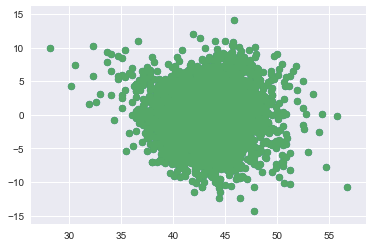

In [1353]:
regression_evaluation(reg_df.over_under_line, reg_df.total_ppg)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     1575.
Date:                Thu, 09 Aug 2018   Prob (F-statistic):          4.17e-275
Time:                        19:23:01   Log-Likelihood:                 2900.8
No. Observations:                2880   AIC:                            -5798.
Df Residuals:                    2878   BIC:                            -5786.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4158      0.009    385.999      0.0

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



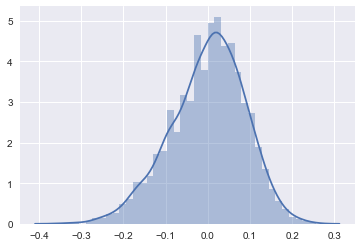

In [1255]:
log_regression_evaluation(reg_df.over_under_line, reg_df.total_ppg)

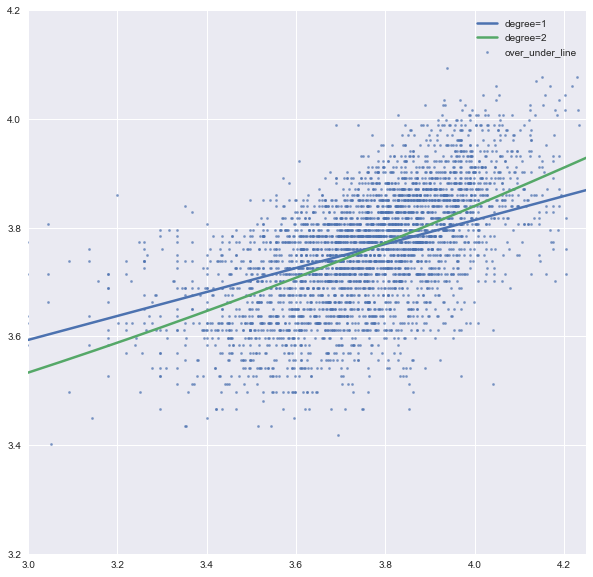

In [1062]:
log_log_regression(reg_df.total_ppg,reg_df.over_under_line,[1,2],3,4.25,3.2,4.2,0,5)